In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, simps
from mpl_toolkits.mplot3d import axes3d
# import pymsteams
from time import time, localtime, strftime
from datetime import datetime
import os
# from scipy.interpolate import RegularGridInterpolator as rgi, interp1d
plt.rcParams['figure.figsize'] = [8, 4]
# plt.rcParams.update({'font.size' : 18})

path = r'/home/teamgem/Heriot-Watt University Team Dropbox/RES_EPS_Quantum_Photonics_Lab/Experiments/Current Experiments/Visible Quantum Memory/GEM and Stark shift/20240819_GEM_MBE_sims/'
# path = r'C:\Users\fgbse\Heriot-Watt University Team Dropbox\RES_EPS_Quantum_Photonics_Lab\Experiments\Current Experiments\Visible Quantum Memory\GEM and Stark shift\20240815_GEM_MBE_sims'
# path = r'C:\Users\Finley Giles-Book\Heriot-Watt University Team Dropbox\RES_EPS_Quantum_Photonics_Lab\Experiments\Current Experiments\Visible Quantum Memory\GEM and Stark shift\20240815_GEM_MBE_sims'

In [2]:
def lorentz(x,delta,lw,grad,stark,length):
    line_shape = 1/((np.pi * (lw + grad*length/2*stark)*(1 + ((delta + grad*stark*x)/(lw + grad*length/2*stark))**2)))
    return line_shape/max(1/((np.pi * (lw)*(1 + ((delta)/(lw))**2))))

def lorentz(x,delta,lw,grad,stark,length):
    line_shape = 1/((np.pi * (lw + grad*length/2*stark)*(1 + ((delta + grad*stark*x)/(lw + grad*length/2*stark))**2)))
    return line_shape

def lorentz_abs_prof(x,delta,lw,OD,grad,stark,length):
    line_shape = 1/(2*np.pi) * (lw + grad*length/2*stark)/((delta + grad*stark*x)**2 + (1/2*(lw + grad*length/2*stark))**2)
    return OD*line_shape/max(1/(2*np.pi) * lw/(delta**2 + (1/2*lw)**2))

def rect_abs_prof(x,delta,lw,OD,grad,stark,length):
    line_shape = np.where(abs(delta + grad*stark*x) <= (lw + grad*length/2*stark), OD*lw/(lw + grad*length/2*stark), 0)
    return line_shape

def gauss_abs_prof(x,delta,lw,OD,grad,stark,length):
    line_shape = 1/((lw + grad*length/2*stark)*np.sqrt(2*np.pi)) * np.exp(-1/2 * (delta + grad*stark*x)**2/(lw)**2)
    return OD*line_shape/max(1/(lw*np.sqrt(2*np.pi)) * np.exp(-1/2 * delta**2/lw**2))

def grad_switch(t,t_switch):
    if t > t_switch:
        return 1
    else:
        return -1
    
def gauss(t,t_peak,amp,sigma):    
    line_shape = amp*np.exp(-(t - t_peak)**2 / (2 * sigma**2))
    return line_shape

def MBE_pol_z0(t, alpha, t0, A, sigma, delta, x, grad, stark, t_switch, g, gamma, w):

    E = gauss(t,t0,A,sigma)

    dalpha_dt = -(gamma/2)*alpha - (1j) * (delta + grad * stark * grad_switch(t_switch,t) * x)*alpha - (1j) * g * w * E

    return dalpha_dt

def interpolate_E_t(E,t_arr,tn):

    interp = np.interp(tn,t_arr,E)
    return interp

def interpolate_E_z(E,x_arr,xn):

    interp = np.interp(xn,x_arr,E)
    return interp

def MBE_pol_z(t, alpha, E, t_arr, delta, x_n, grad, stark, t_switch, g, gamma, w):
    
    Ez = interpolate_E_t(E,t_arr,t)

    dalpha_dt = -(gamma/2)*alpha - (1j) * (delta + grad * stark * grad_switch(t_switch,t) * x_n)*alpha - (1j) * g * w * Ez

    return dalpha_dt

def MBE_field(x, E, delta, t0, t1, alpha0, E0, t_arr, x_arr, grad, stark, t_switch, g, gamma, w0, OD, lw, L):

    # Calculate the optical field over dz
    # Since the the function calculates the spatial derivative of 
    # E and the eqn does not include any terms with E then then initial value of E is not needed
    # rhs_int is the initial value

    # E1 = E0-E[:,0]*np.log(-OD)
    # E1 = E0-E[:,0]
    # E1 = E0
    # E1 = E[:,0]
    E1 = E0*np.exp(-OD*x/L)

    # print(np.shape(E[:,0]))

    sol_alpha_z = solve_ivp(MBE_pol_z,
                            (t0, t1),
                            alpha0,
                            args=(E1, t_arr, delta, x, grad, stark, t_switch, g, gamma, w0),
                            t_eval=t_arr,
                            dense_output=True,
                            vectorized=False,
                            method='RK23')
        
    alpha = sol_alpha_z.y.T

    dE_dx = -simps(rect_abs_prof(x_arr,delta,lw,OD,grad,stark,L)*alpha,x=delta,axis=1)

    print(x)

    return dE_dx

In [3]:
def rect_abs_prof_1(x,delta,lw,OD,grad,stark,length):
    line_shape = np.where(abs(delta - grad*stark*x) <= (lw), OD*lw/(lw + grad*length/2*stark), 0)
    return line_shape

def MBE_field(x, E, delta, t0, t1, alpha0, E0, t_arr, x_arr, grad, stark, t_switch, g, gamma, w0, OD, lw, L):

    # Calculate the optical field over dz
    # Since the the function calculates the spatial derivative of 
    # E and the eqn does not include any terms with E then then initial value of E is not needed
    # rhs_int is the initial value

    # E1 = E0-E[:,0]*np.log(-OD)
    # E1 = E0-E[:,0]
    # E1 = E0
    # E1 = E[:,0]
    E1 = E0*np.exp(-OD*x/L)

    # print(np.shape(E[:,0]))

    sol_alpha_z = solve_ivp(MBE_pol_z,
                            (t0, t1),
                            alpha0,
                            args=(E1, t_arr, delta, x, grad, stark, t_switch, g, gamma, w0),
                            t_eval=t_arr,
                            dense_output=True,
                            vectorized=False,
                            method='RK45')
        
    alpha = sol_alpha_z.y.T

    # dE_dx = 

    dE_dx = -simps(rect_abs_prof_1(x,delta,lw,OD/L,grad,stark,L)*alpha,axis=1)

    print(x)

    return dE_dx

In [4]:
# Parameters - converted assuming that k0/2e0 = lambda (wavelength) = 1

gamma = 0.31#0.01#0.31                            # Polarization decay rate
g = 2000#2000#406                                 # Transition coupling strength
t_input = 10                                 # Gaussian pulse peak time
sigma = 0.5/np.sqrt(2*np.log(2))        # Gaussian pulse sigma
OD = 1                               # Optical depth used in Lorentzian
grad = 1E7#7.37e-11                         # Electric field gradient
stark = 6.74e-10                        # Stark coefficient
lw = 0.05                                  # Zero field absorption linewidth
t_switch = 25                            # Gradient direction switch time
A = 3.5e-3#3                              # Electric field magnitude
L = 16475/2                               # Optical path length
t_total = 50
w0 = -1                                 # Atomic excitation field

# Discretisation

Nx = 200          # Spatial grid  
x_arr = np.linspace(-L/2, L/2, Nx)
x0 = x_arr[0]
x1 = x_arr[-1]

Nt = 200            # Time grid
t_arr = np.linspace(0,t_total, Nt)
t0 = t_arr[0]
t1 = t_arr[-1]

Nd = 200
delta_range = 20  # Detuning grid
delta = np.linspace(-delta_range/2, delta_range/2, Nd)
d0 = delta[0]
d1 = delta[-1]

# Initialisation

alpha0 = np.zeros(Nd, dtype=np.complex128)
E0 = np.complex128(gauss(t_arr,t_input,A,sigma))

alpha = np.zeros((Nd, Nt, Nx), dtype=np.complex128)
E = np.zeros((Nt, Nx), dtype=np.complex128)
P = np.zeros((Nt, Nx), dtype=np.complex128)

# E[0,:] = E0

t_E_start = time()

sol = solve_ivp(MBE_field,
                (x0, x1),
                E0,
                args=(delta, t0, t1, alpha0, E0, t_arr, x_arr, grad, stark, t_switch, g, gamma, w0, OD, lw, L),
                t_eval=x_arr,
                dense_output=True,
                vectorized=True,
                method='RK45')
    
E = sol.y

with open(os.path.join(path,r'E.npy'),'wb') as f:
    np.save(f, E)

t_E = time() - t_E_start

t_alpha_start = time()

# alpha
for i in range(Nx):
    sol_alpha_z = solve_ivp(MBE_pol_z,
                            (t0, t1),
                            alpha0,
                            args=(E[:,i], t_arr, delta, x_arr[i], grad, stark, t_switch, g, gamma, w0),
                            # args=(E0, t_arr, delta, x_arr[i], grad, stark, t_switch, g, gamma, w0),
                            t_eval=t_arr,
                            dense_output=True,
                            vectorized=False,
                            method='RK45')
    print(i)
    
    alpha[:,:,i] = sol_alpha_z.y

with open(os.path.join(path,r'alpha.npy'),'wb') as f:
    np.save(f, alpha)

t_alpha = time() - t_alpha_start

t_P_start = time()

P = 1j * simps(rect_abs_prof(x_arr,delta,lw,OD,grad,stark,L)*alpha,axis=2)

with open(os.path.join(path + r'P.npy'),'wb') as f:
    np.save(f, P)

t_P = time() - t_P_start

E = np.rot90(E)
# P = np.rot90(P)

-4118.75
-4118.749999
-4118.7499998
-4118.7499996999995
-4118.749999199999
-4118.749999111111
-4118.749999
-4118.749999
-4118.749996999999
-4118.749995999999
-4118.749990999997
-4118.749990111108
-4118.749988999996
-4118.749988999996
-4118.7499689999895
-4118.749958999986
-4118.749908999969
-4118.749900111077
-4118.749888999962
-4118.749888999962
-4118.749688999895
-4118.749588999861
-4118.749088999692
-4118.749000110773
-4118.748888999624
-4118.748888999624
-4118.746888998947
-4118.745888998608
-4118.740888996916
-4118.740000107726
-4118.7388889962385
-4118.7388889962385
-4118.718888989468
-4118.7088889860825
-4118.658888969156
-4118.650000077258
-4118.638888962385
-4118.638888962385
-4118.438888894678
-4118.338888860824
-4117.838888691556
-4117.749999772575
-4117.638888623849
-4117.638888623849
-4115.638887946778
-4114.638887608242
-4109.638885915563
-4108.749996725754
-4107.638885238492
-4107.638885238492
-4087.6388784677765
-4077.638875082419
-4027.638858155631
-4018.7499662575356


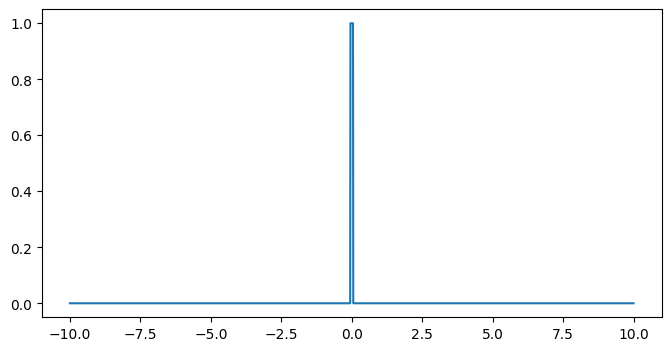

In [58]:
def square_pulses(width, centers, amplitude, length):
    """
    Creates multiple square pulses.

    Args:
        widths: A list of widths for each pulse.
        centers: A list of central positions for each pulse.
        amplitude: Amplitude of all pulses.
        length: Length of the output array.

    Returns:
        A numpy array containing the sum of all square pulses.
    """

    pulses = np.zeros(length)
    for center in centers:
        pulse = np.zeros(length)
        pulse[(np.arange(length) >= center - width/2) & (np.arange(length) < center + width/2)] = amplitude
        pulses += pulse
    return pulses

def frequency_square_pulse(center_freq, width, amplitude, freq_resolution):
  """
  Creates a square pulse in the frequency domain.

  Args:
    center_freq: Center frequency of the pulse.
    width: Width of the pulse.
    amplitude: Amplitude of the pulse.
    freq_resolution: Frequency resolution of the output array.

  Returns:
    A numpy array representing the frequency domain square pulse.
  """

  freq_axis = np.arange(-10, 10 + freq_resolution, freq_resolution)
  pulse = np.zeros_like(freq_axis)
  pulse[(freq_axis >= center_freq - width/2) & (freq_axis < center_freq + width/2)] = amplitude
  return pulse

# plt.plot(frequency_square_pulse(10,1,1,0.01))

grad = 1E5
stark = 6.74e-10                        # Stark coefficient
lw = 0.05 
Nd = 2000
delta_range = 20  # Detuning grid
delta = np.linspace(-delta_range/2, delta_range/2, Nd)

def rect_abs_prof(delta, centre_freq, lw, OD):
   
    pulse = np.zeros_like(delta)
    pulse[(delta >= centre_freq - lw/2) & (delta < centre_freq + lw/2)] = OD
    return pulse

plt.plot(delta, rect_abs_prof(delta, 0, 0.1, 1))

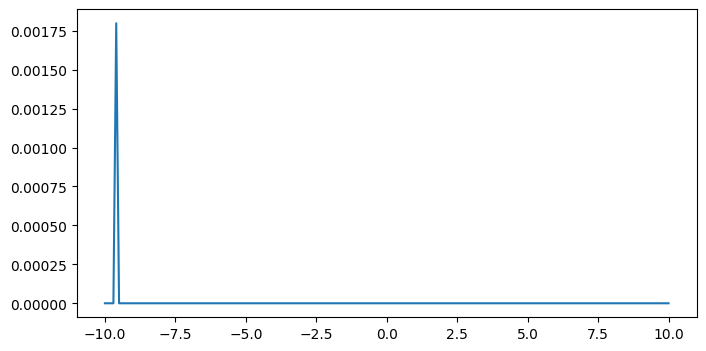

In [21]:
plt.plot(delta,rect_abs_prof_1(x_arr[65],delta,lw,OD,grad,stark,L))

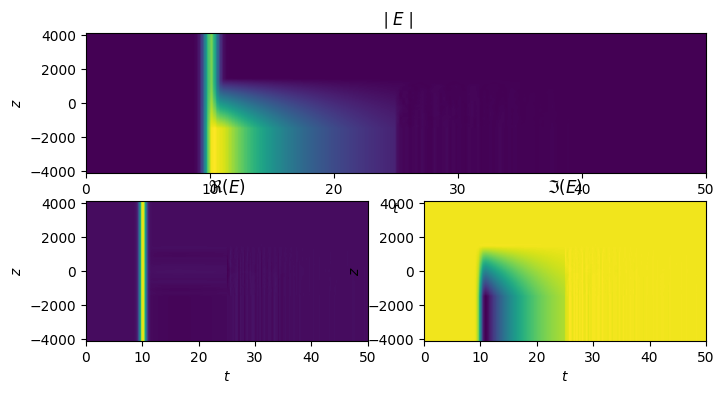

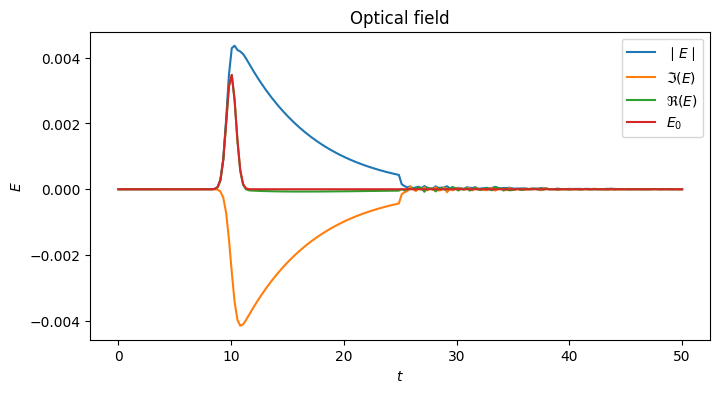

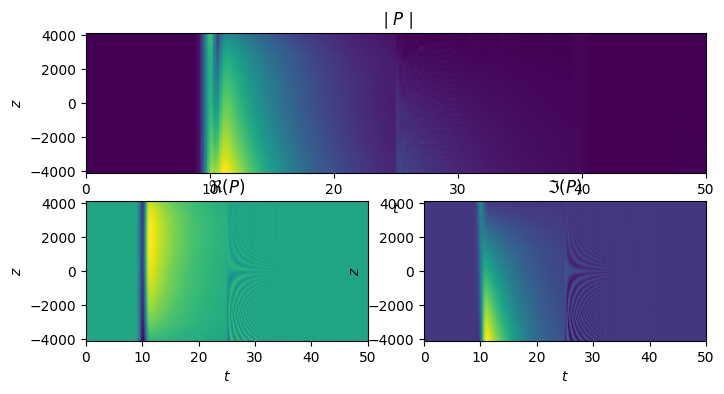

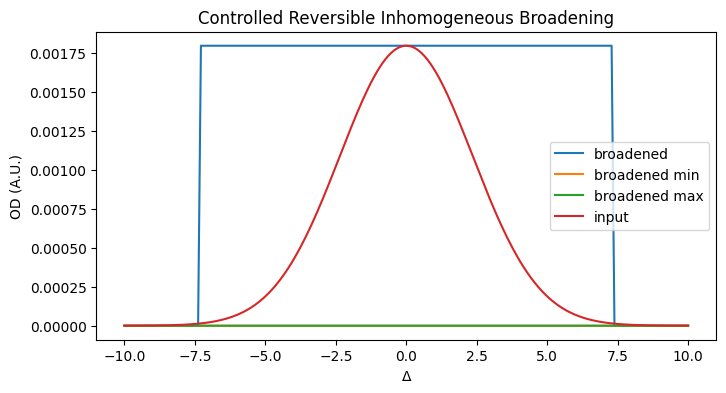

In [322]:
plt.subplot(2,1,1)
plt.imshow(abs(E),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(abs(E),aspect='auto',origin='lower')
plt.title(r'$\mid E \mid$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,3)
plt.imshow(np.real(E),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(np.real(E),aspect='auto',origin='lower')
plt.title(r'$\Re(E)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,4)
plt.imshow(np.imag(E),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(np.imag(E),aspect='auto',origin='lower')
plt.title(r'$\Im(E)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.savefig(os.path.join(path,r'optical field'))

plt.figure()
# plt.plot(t_arr,abs(E[-1,:]),label=r'$\mid E \mid$')
plt.plot(t_arr,abs(E[0,:]),label=r'$\mid E \mid$')
plt.plot(t_arr,np.imag(E[0,:]),label=r'$\Im(E)$')
plt.plot(t_arr,np.real(E[0,:]),label=r'$\Re(E)$')
plt.plot(t_arr,abs(E0),label=r'$E_0$')
plt.title(r'Optical field')
plt.xlabel(r'$t$')
plt.ylabel(r'$E$')
plt.legend()
plt.savefig(os.path.join(path,r'optical field 2D'))

# plt.figure()
# # alpha_sum = np.rot90(np.sum(alpha, axis=2))
# alpha_sum = np.rot90(np.sum(alpha, axis=2))
# plt.subplot(2,1,1)
# plt.imshow(abs(alpha_sum),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# # plt.imshow(abs(alpha_sum),aspect='auto',origin='lower')
# plt.title(r'$\mid \alpha \mid$')
# plt.xlabel(r'$t$')
# plt.ylabel(r'$z$')
# plt.subplot(2,2,3)
# plt.imshow(np.real(alpha_sum),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# # plt.imshow(np.real(alpha_sum),aspect='auto',origin='lower')
# plt.title(r'$\Re(\alpha)$')
# plt.xlabel(r'$t$')
# plt.ylabel(r'$z$')
# plt.subplot(2,2,4)
# plt.imshow(np.imag(alpha_sum),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# # plt.imshow(np.imag(alpha_sum),aspect='auto',origin='lower')
# plt.title(r'$\Im(\alpha)$')
# plt.xlabel(r'$t$')
# plt.ylabel(r'$z$')
# plt.savefig(os.path.join(path,r'atomic polarization'))

plt.figure()
plt.subplot(2,1,1)
plt.imshow(abs(P),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(abs(P),aspect='auto',origin='lower')
plt.title(r'$\mid P \mid$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,3)
plt.imshow(np.real(P),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(np.real(P),aspect='auto',origin='lower')
plt.title(r'$\Re(P)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,4)
plt.imshow(np.imag(P),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(np.imag(P),aspect='auto',origin='lower')
plt.title(r'$\Im(P)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.savefig(os.path.join(path,r'polarization density'))

plt.figure()
# plt.plot(delta,rect_abs_prof_1(x_arr,delta,lw,OD,0,stark,L),label='unbroadened')
plt.plot(delta,rect_abs_prof(x_arr,delta,lw,OD,grad,stark,L),label='broadened')
plt.plot(delta,rect_abs_prof_1(x_arr[95],delta,lw,OD/L,grad,stark,L),label='broadened min')
plt.plot(delta,rect_abs_prof_1(x_arr[105],delta,lw,OD/L,grad,stark,L),label='broadened max')
plt.plot(delta,gauss(delta,0,OD*lw/(lw + grad*L/2*stark),1/sigma),label='input')
plt.xlabel(r'$\Delta$')
plt.ylabel(r'OD (A.U.)')
plt.title('Controlled Reversible Inhomogeneous Broadening')
plt.legend()
plt.savefig(os.path.join(path,r'controlled reversible inhomogeneous broadening'))

plt.show()

with open(os.path.join(path,'params.txt'), 'w') as f:
    f.writelines('MBE simulations params\n')
    f.writelines(f'{strftime("%d/%m/%Y %H:%M:%S")}\n')
    f.writelines('\n')
    f.writelines(f'E calculation time = {t_E}\n')
    f.writelines(f'alpha calculation time = {t_alpha}\n')
    f.writelines(f'P calculation time = {t_P}\n')
    f.writelines('\n')
    f.writelines(f'gamma = {gamma}\n')
    f.writelines(f'g = {g}\n')
    f.writelines(f't_input = {t_input}\n')
    f.writelines(f'sigma = {sigma}\n')
    f.writelines(f'OD = {OD}\n')
    f.writelines(f'grad = {grad}\n')
    f.writelines(f'stark = {stark}\n')
    f.writelines(f'lw = {lw}\n')
    f.writelines(f't_switch = {t_switch}\n')
    f.writelines(f'A = {A}\n')
    f.writelines(f'L = {L}\n')
    f.writelines(f't_total = {t_total}\n')
    f.writelines(f'w0 = {w0}\n')
    f.writelines(f'Nx = {Nx}\n')
    f.writelines(f'Nt = {Nt}\n')
    f.writelines(f'Nd = {Nd}\n')
    f.writelines(f'delta_range = {delta_range}\n')

# myTeamsMessage = pymsteams.connectorcard("https://heriotwatt.webhook.office.com/webhookb2/36c66bd3-00f2-4593-9e53-9c5f95266f6b@6c425ff2-6865-42df-a4db-8e6af634813d/IncomingWebhook/bfb3c210c4e246a0b921828743844f4c/7c7eb11d-34da-4e09-abca-fcaefc441bad")
# myTeamsMessage.text("Neutroooooooooon, your simulations are done NERD!")
# myTeamsMessage.send()

IndexError: index 200 is out of bounds for axis 0 with size 200

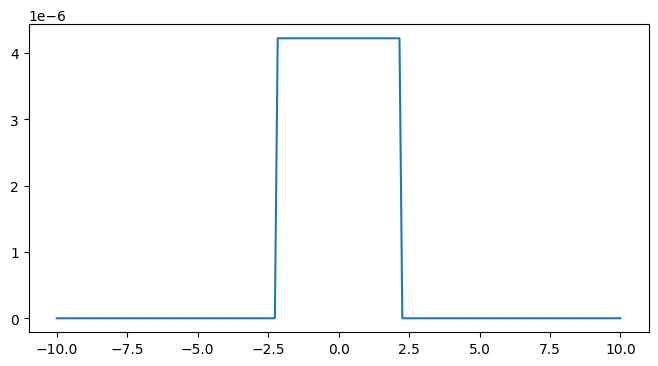

In [312]:
lw = 0.1
OD = 1
grad = 1E6
sigma = 0.5

Nx = 200          # Spatial grid  
x_arr = np.linspace(-L/2, L/2, Nx)
x0 = x_arr[0]
x1 = x_arr[-1]

Nt = 200            # Time grid
t_arr = np.linspace(0,t_total, Nt)
t0 = t_arr[0]
t1 = t_arr[-1]

Nd = 200
delta_range = 20  # Detuning grid
delta = np.linspace(-delta_range/2, delta_range/2, Nd)
d0 = delta[0]
d1 = delta[-1]

def rect_abs_prof_1(x,delta,lw,OD,grad,stark,length):
    line_shape = np.where(abs(delta + grad*stark*x) <= (lw), OD*lw/(lw + grad*length/2*stark), 0)
    return line_shape

def rect_abs_prof(x,delta,lw,OD,grad,stark,length):
    line_shape = np.where(abs(delta + grad*stark*x) <= (lw + grad*length/2*stark), OD*lw/(lw + grad*length/2*stark), 0)
    return line_shape

plt.figure()
# plt.plot(delta,rect_abs_prof_1(x_arr,delta,lw,OD,grad,0,L),label='unbroadened')
plt.plot(delta,rect_abs_prof(x_arr,delta,lw,OD/L,grad,stark,L),label='broadened')
# plt.plot(delta,gauss(delta,0,OD/L*lw/(lw + grad*L/2*stark),1/(sigma)),label='input')
plt.plot(delta,rect_abs_prof_1(x_arr[200],delta,lw,OD/L,grad,stark,L),label='broadened')
plt.xlabel(r'$\Delta$')
plt.ylabel(r'OD (A.U.)')
plt.title('Controlled Reversible Inhomogeneous Broadening')
plt.legend()

In [91]:
# Parameters - converted assuming that k0/2e0 = lambda (wavelength) = 1

gamma = 3.1E5                            # Polarization decay rate
g = 246.45                                 # Transition coupling strength
t_input = 5E-6                                 # Gaussian pulse peak time
sigma = 1E-6                            # Gaussian pulse sigma
OD = 10                                  # Optical depth used in Lorentzian
grad = 5E5                         # Electric field gradient
stark = 1116                        # Stark coefficient
lw = 0.25E6                                  # Zero field absorption linewidth
t_switch = 15E-6                            # Gradient direction switch time
A = 577                              # Electric field magnitude
L = 1E-2                               # Optical path length
t_total = 50E-6
w0 = -1                                 # Atomic excitation field

# Discretisation

Nx = 200          # Spatial grid  
x_arr = np.linspace(-L/2, L/2, Nx)
x0 = x_arr[0]
x1 = x_arr[-1]

Nt = 200            # Time grid
t_arr = np.linspace(0,t_total, Nt)
t0 = t_arr[0]
t1 = t_arr[-1]

Nd = 200
delta_range = 20E6  # Detuning grid
delta = np.linspace(-delta_range/2, delta_range/2, Nd)
d0 = delta[0]
d1 = delta[-1]

# Initialisation

alpha0 = np.zeros(Nd, dtype=np.complex128)
E0 = np.complex128(gauss(t_arr,t_input,A,sigma))

alpha = np.zeros((Nd, Nt, Nx), dtype=np.complex128)
E = np.zeros((Nt, Nx), dtype=np.complex128)
P = np.zeros((Nt, Nx), dtype=np.complex128)

# E[0,:] = E0

t_E_start = time()

sol = solve_ivp(MBE_field,
                (x0, x1),
                E0,
                args=(delta, t0, t1, alpha0, E0, t_arr, x_arr, grad, stark, t_switch, g, gamma, w0, OD, lw, L),
                t_eval=x_arr,
                dense_output=True,
                vectorized=True,
                method='RK45')
    
E = sol.y

with open(os.path.join(path,r'E.npy'),'wb') as f:
    np.save(f, E)

t_E = time() - t_E_start

t_alpha_start = time()

# alpha
for i in range(Nx):
    sol_alpha_z = solve_ivp(MBE_pol_z,
                            (t0, t1),
                            alpha0,
                            args=(E[:,i], t_arr, delta, x_arr[i], grad, stark, t_switch, g, gamma, w0),
                            # args=(E0, t_arr, delta, x_arr[i], grad, stark, t_switch, g, gamma, w0),
                            t_eval=t_arr,
                            dense_output=True,
                            vectorized=False,
                            method='RK45')
    print(i)
    
    alpha[:,:,i] = sol_alpha_z.y

with open(os.path.join(path,r'alpha.npy'),'wb') as f:
    np.save(f, alpha)

t_alpha = time() - t_alpha_start

t_P_start = time()

# for i in range(Nx):
#     P[:,i] = simps(rect_abs_prof_1(x_arr[i],delta,lw,OD,grad,stark,L)*alpha,axis=2)
# P = np.sum(P,axis=2)
P = 1j * simps(rect_abs_prof_1(x_arr,delta,lw,OD,grad,stark,L)*alpha,axis=2)

with open(os.path.join(path + r'P.npy'),'wb') as f:
    np.save(f, P)

t_P = time() - t_P_start

E = np.rot90(E)
# P = np.rot90(P)

-0.005
-0.004999996499011838
-0.00499992998023677
-0.004999894970355156
-0.004999719920947083
-0.004999688801052314
-0.004999649901183853
-0.004999649901183853
-0.00499956315816296
-0.004999519786652514
-0.0049993029291002826
-0.004999264376646552
-0.00499921618607939
-0.00499921618607939
-0.0049990898562777344
-0.004999026691376907
-0.004998710866872769
-0.004998654720294256
-0.004998584537071114
-0.004998584537071114
-0.004997321239054562
-0.004996689590046286
-0.0049935313450049056
-0.0049929698792197715
-0.0049922680469883535
-0.0049922680469883535
-0.004987289851060635
-0.004984800753096775
-0.004972355263277478
-0.004970142731754048
-0.00496737706734976
-0.00496737706734976
-0.0049600602110991205
-0.004956401782973801
-0.004938109642347203
-0.004934857706235808
-0.0049307927860965635
-0.0049307927860965635
-0.004923909977661758
-0.004920468573444355
-0.004903261552357341
-0.004900202526386317
-0.004896378743922535
-0.004896378743922535
-0.004888132958162987
-0.004884010065283212


In [ ]:
gamma = 3.1E5                            # Polarization decay rate
g = 246.45                                 # Transition coupling strength
t_input = 5E-6                                 # Gaussian pulse peak time
sigma = 1E-6                            # Gaussian pulse sigma
OD = 1                                  # Optical depth used in Lorentzian
grad = 5E5                         # Electric field gradient
stark = 1116                        # Stark coefficient
lw = 0.25E6                                  # Zero field absorption linewidth
t_switch = 15E-6                            # Gradient direction switch time
A = 577                              # Electric field magnitude
L = 1E-2                               # Optical path length
t_total = 50E-6
w0 = -1                                 # Atomic excitation field

# Discretisation

Nx = 200          # Spatial grid  
x_arr = np.linspace(-L/2, L/2, Nx)
x0 = x_arr[0]
x1 = x_arr[-1]

Nt = 200            # Time grid
t_arr = np.linspace(0,t_total, Nt)
t0 = t_arr[0]
t1 = t_arr[-1]

Nd = 200
delta_range = 20E6  # Detuning grid
delta = np.linspace(-delta_range/2, delta_range/2, Nd)
d0 = delta[0]
d1 = delta[-1]

plt.figure()
plt.plot(delta,rect_abs_prof(x_arr,delta,lw,OD,grad,0,L),label='unbroadened')
plt.plot(delta,rect_abs_prof(x_arr,delta,lw,OD,grad,stark,L),label='broadened')
plt.plot(delta,rect_abs_prof_1(x_arr[100],delta,lw,OD,grad,stark,L),label='broadened')
plt.plot(delta,gauss(delta,0,OD*lw/(lw + grad*L/2*stark),1/sigma),label='input')
plt.xlabel(r'$\Delta$')
plt.ylabel(r'OD (A.U.)')
plt.title('Controlled Reversible Inhomogeneous Broadening')
plt.legend()

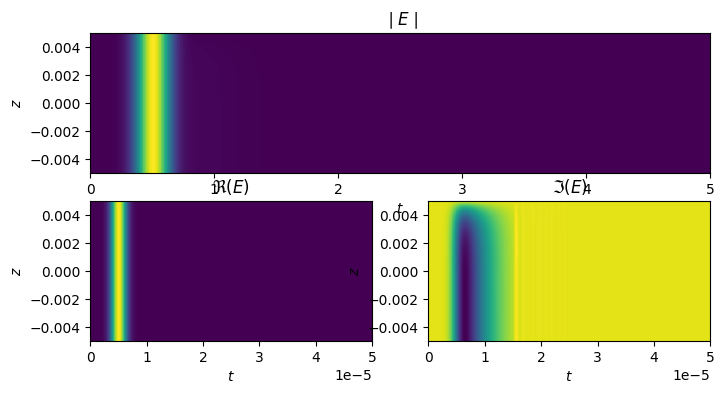

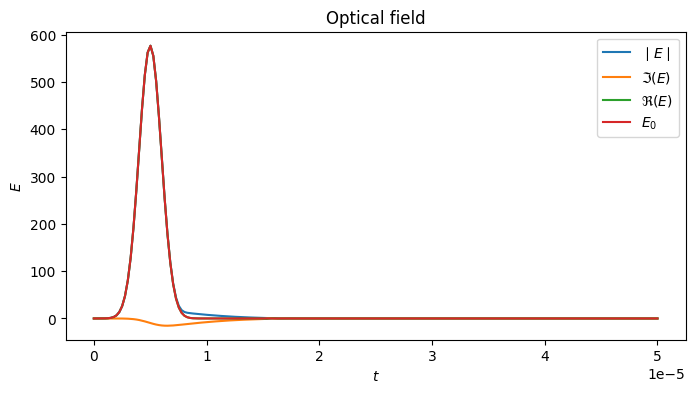

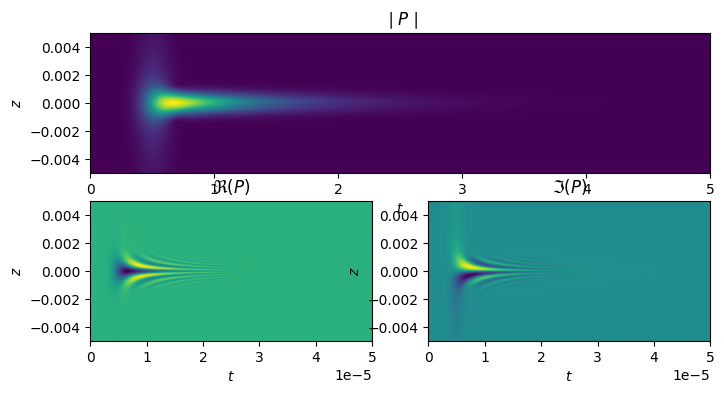

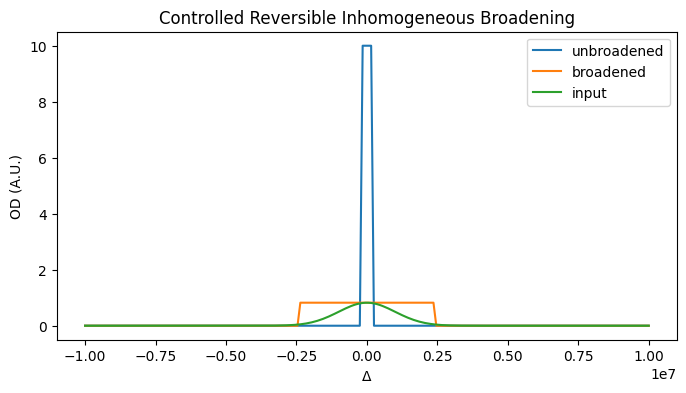

In [92]:
plt.subplot(2,1,1)
plt.imshow(abs(E),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(abs(E),aspect='auto',origin='lower')
plt.title(r'$\mid E \mid$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,3)
plt.imshow(np.real(E),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(np.real(E),aspect='auto',origin='lower')
plt.title(r'$\Re(E)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,4)
plt.imshow(np.imag(E),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(np.imag(E),aspect='auto',origin='lower')
plt.title(r'$\Im(E)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.savefig(os.path.join(path,r'optical field'))

plt.figure()
# plt.plot(t_arr,abs(E[-1,:]),label=r'$\mid E \mid$')
plt.plot(t_arr,abs(E[0,:]),label=r'$\mid E \mid$')
plt.plot(t_arr,np.imag(E[0,:]),label=r'$\Im(E)$')
plt.plot(t_arr,np.real(E[0,:]),label=r'$\Re(E)$')
plt.plot(t_arr,abs(E0),label=r'$E_0$')
plt.title(r'Optical field')
plt.xlabel(r'$t$')
plt.ylabel(r'$E$')
plt.legend()
plt.savefig(os.path.join(path,r'optical field 2D'))

# plt.figure()
# # alpha_sum = np.rot90(np.sum(alpha, axis=2))
# alpha_sum = np.rot90(np.sum(alpha, axis=2))
# plt.subplot(2,1,1)
# plt.imshow(abs(alpha_sum),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# # plt.imshow(abs(alpha_sum),aspect='auto',origin='lower')
# plt.title(r'$\mid \alpha \mid$')
# plt.xlabel(r'$t$')
# plt.ylabel(r'$z$')
# plt.subplot(2,2,3)
# plt.imshow(np.real(alpha_sum),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# # plt.imshow(np.real(alpha_sum),aspect='auto',origin='lower')
# plt.title(r'$\Re(\alpha)$')
# plt.xlabel(r'$t$')
# plt.ylabel(r'$z$')
# plt.subplot(2,2,4)
# plt.imshow(np.imag(alpha_sum),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# # plt.imshow(np.imag(alpha_sum),aspect='auto',origin='lower')
# plt.title(r'$\Im(\alpha)$')
# plt.xlabel(r'$t$')
# plt.ylabel(r'$z$')
# plt.savefig(os.path.join(path,r'atomic polarization'))

plt.figure()
plt.subplot(2,1,1)
plt.imshow(abs(P),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(abs(P),aspect='auto',origin='lower')
plt.title(r'$\mid P \mid$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,3)
plt.imshow(np.real(P),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(np.real(P),aspect='auto',origin='lower')
plt.title(r'$\Re(P)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,4)
plt.imshow(np.imag(P),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(np.imag(P),aspect='auto',origin='lower')
plt.title(r'$\Im(P)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.savefig(os.path.join(path,r'polarization density'))

plt.figure()
plt.plot(delta,rect_abs_prof(x_arr,delta,lw,OD,grad,0,L),label='unbroadened')
plt.plot(delta,rect_abs_prof(x_arr,delta,lw,OD,grad,stark,L),label='broadened')
plt.plot(delta,gauss(delta,0,OD*lw/(lw + grad*L/2*stark),1/sigma),label='input')
plt.xlabel(r'$\Delta$')
plt.ylabel(r'OD (A.U.)')
plt.title('Controlled Reversible Inhomogeneous Broadening')
plt.legend()
plt.savefig(os.path.join(path,r'controlled reversible inhomogeneous broadening'))

plt.show()

with open(os.path.join(path,'params.txt'), 'w') as f:
    f.writelines('MBE simulations params\n')
    f.writelines(f'{strftime("%d/%m/%Y %H:%M:%S")}\n')
    f.writelines('\n')
    f.writelines(f'E calculation time = {t_E}\n')
    f.writelines(f'alpha calculation time = {t_alpha}\n')
    f.writelines(f'P calculation time = {t_P}\n')
    f.writelines('\n')
    f.writelines(f'gamma = {gamma}\n')
    f.writelines(f'g = {g}\n')
    f.writelines(f't_input = {t_input}\n')
    f.writelines(f'sigma = {sigma}\n')
    f.writelines(f'OD = {OD}\n')
    f.writelines(f'grad = {grad}\n')
    f.writelines(f'stark = {stark}\n')
    f.writelines(f'lw = {lw}\n')
    f.writelines(f't_switch = {t_switch}\n')
    f.writelines(f'A = {A}\n')
    f.writelines(f'L = {L}\n')
    f.writelines(f't_total = {t_total}\n')
    f.writelines(f'w0 = {w0}\n')
    f.writelines(f'Nx = {Nx}\n')
    f.writelines(f'Nt = {Nt}\n')
    f.writelines(f'Nd = {Nd}\n')
    f.writelines(f'delta_range = {delta_range}\n')

# myTeamsMessage = pymsteams.connectorcard("https://heriotwatt.webhook.office.com/webhookb2/36c66bd3-00f2-4593-9e53-9c5f95266f6b@6c425ff2-6865-42df-a4db-8e6af634813d/IncomingWebhook/bfb3c210c4e246a0b921828743844f4c/7c7eb11d-34da-4e09-abca-fcaefc441bad")
# myTeamsMessage.text("Neutroooooooooon, your simulations are done NERD!")
# myTeamsMessage.send()